In [1]:
import matplotlib.pyplot as plt
from preprocessing import get_ml_data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
city = 2304400
ini_date = None
end_train_date = None
end_date = None
predict_n = 4
look_back = 4
ratio = 0.75

filename = f'../../data/combined_data_{city}.csv'

### Capturando os dados: 

In [3]:

X_data, X_train, targets, target = get_ml_data(city, ini_date = ini_date, end_train_date = end_train_date, end_date = end_date, 
                                        ratio = ratio , predict_n = predict_n, look_back = look_back, filename = filename)


In [4]:
X_data.shape

(695, 432)

In [5]:
X_train.shape

(521, 432)

In [6]:
d = 4 # o alvo é o número de casos na semana daqui a 4 semanas
y_train = targets[d][:len(X_train)]

len(y_train)

521

In [7]:
y_data = targets[d]

len(y_data)

691

### Criando um modelo ML simples (random forest):

In [8]:
model = Pipeline([('scaling', StandardScaler()),
#                 ('feature_selection', SelectFromModel(RandomForestRegressor())),
                ('regression', RandomForestRegressor())])
model.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regression', RandomForestRegressor())])

In [9]:
pred = model.predict(X_data[:len(targets[d])].values)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [10]:
len(target[d:].index)

691

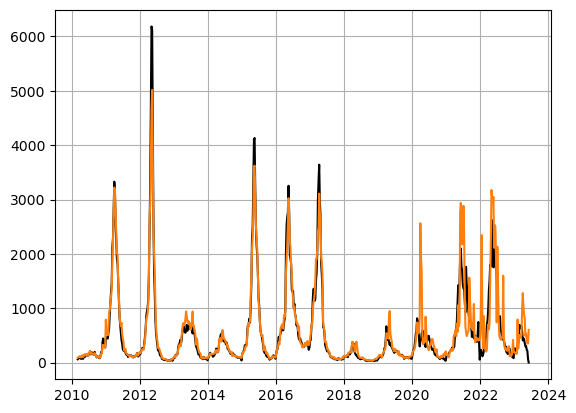

In [11]:
fig, ax = plt.subplots()

ax.plot(target[d:], label = 'Data', color = 'black')

ax.plot(target[d:].index, pred, label = 'Model', color = 'tab:orange')
ax.grid()

plt.show()

### Usando conformal regresor to predict the confidence interval: 

In [12]:
from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.extras import hinge, margin, binning, DifficultyEstimator

In [13]:
model2 =  RandomForestRegressor(oob_score=True) 

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

model2.fit(X_prop_train, y_prop_train)

RandomForestRegressor(oob_score=True)

In [14]:
# create a conformal regression instance 
cr_std = ConformalRegressor()

In [15]:
display(cr_std)

ConformalRegressor(fitted=False)

In [16]:
y_hat_cal = model2.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [17]:
X_test = X_data[X_train.shape[0]:len(y_data)]
y_test = y_data[X_train.shape[0]:]


In [18]:
X_test.shape

(170, 432)

In [19]:
y_test.shape

(170,)

In [20]:
y_hat_test = model2.predict(X_test)

intervals = cr_std.predict(y_hat_test, confidence=0.95, y_min = 0)

display(intervals)

array([[   0.  , 1890.71],
       [   0.  , 1857.27],
       [   0.  , 1866.03],
       [ 983.35, 3420.01],
       [   0.  , 1969.85],
       [   0.  , 1906.92],
       [   0.  , 1710.39],
       [   0.  , 1573.1 ],
       [   0.  , 1586.74],
       [   0.  , 1539.73],
       [   0.  , 1813.08],
       [   0.  , 1736.78],
       [   0.  , 1707.73],
       [   0.  , 1600.71],
       [   0.  , 1522.59],
       [   0.  , 1461.65],
       [   0.  , 1474.75],
       [   0.  , 1467.52],
       [   0.  , 1483.05],
       [   0.  , 1521.11],
       [   0.  , 1571.83],
       [   0.  , 1567.56],
       [   0.  , 1503.76],
       [   0.  , 1480.59],
       [   0.  , 1468.11],
       [   0.  , 1450.61],
       [   0.  , 1396.62],
       [   0.  , 1416.42],
       [   0.  , 1450.76],
       [   0.  , 1337.39],
       [   0.  , 1330.57],
       [   0.  , 1319.88],
       [   0.  , 1312.2 ],
       [   0.  , 1312.07],
       [   0.  , 1333.54],
       [   0.  , 1326.64],
       [   0.  , 1315.56],
 

In [21]:
intervals.shape

(170, 2)

In [22]:
intervals[:, 0].shape

(170,)

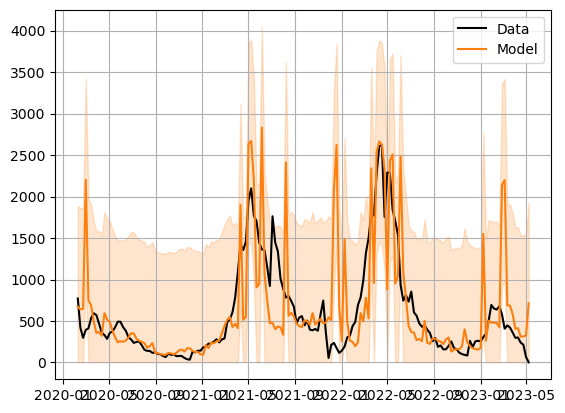

In [23]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals[:,0], intervals[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [24]:
%%time
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

sigmas_cal_knn_dist = de_knn.apply(X_cal)

cr_norm_knn_dist = ConformalRegressor()

cr_norm_knn_dist.fit(residuals_cal, sigmas=sigmas_cal_knn_dist)

display(cr_norm_knn_dist)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

CPU times: user 95.6 ms, sys: 14 ms, total: 110 ms
Wall time: 34.7 ms


In [25]:
sigmas_test_knn_dist = de_knn.apply(X_test)

intervals_norm_knn_dist = cr_norm_knn_dist.predict(y_hat_test, 
                                                   sigmas=sigmas_test_knn_dist,
                                                   y_min=0)

display(intervals_norm_knn_dist)

array([[   0.        , 1774.9786498 ],
       [   0.        , 1641.99985669],
       [   0.        , 1644.72404948],
       [1292.23544284, 3111.12455716],
       [   0.        , 1603.1469019 ],
       [   0.        , 1631.32155336],
       [   0.        , 1472.53437456],
       [   0.        , 1450.24123604],
       [   0.        , 1414.96332802],
       [   0.        , 1336.85319606],
       [   0.        , 1582.73671452],
       [   0.        , 1422.08622347],
       [   0.        , 1718.87705404],
       [   0.        , 1615.10185983],
       [   0.        , 1661.86849543],
       [   0.        , 1474.72714643],
       [   0.        , 1349.84985764],
       [   0.        , 1343.14979868],
       [   0.        , 1447.27845805],
       [   0.        , 1617.096726  ],
       [   0.        , 1613.26041298],
       [   0.        , 1691.29904429],
       [   0.        , 1539.04734161],
       [   0.        , 1687.79680203],
       [   0.        , 1615.36074126],
       [   0.        , 15

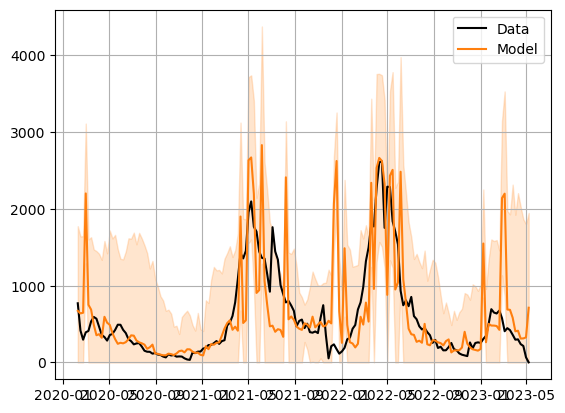

In [26]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_dist[:,0], intervals_norm_knn_dist[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [27]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(X_cal)

cr_norm_knn_std = ConformalRegressor()

cr_norm_knn_std.fit(residuals_cal, sigmas=sigmas_cal_knn_std)

display(cr_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [28]:
sigmas_test_knn_std = de_knn_std.apply(X_test)

intervals_norm_knn_std = cr_norm_knn_std.predict(y_hat_test, 
                                                 sigmas=sigmas_test_knn_std,
                                                 y_min=0)

display(intervals_norm_knn_std)

array([[0.00000000e+00, 2.51825678e+03],
       [0.00000000e+00, 2.57333924e+03],
       [0.00000000e+00, 2.59089151e+03],
       [0.00000000e+00, 5.83895010e+03],
       [0.00000000e+00, 3.54012396e+03],
       [0.00000000e+00, 3.45826389e+03],
       [0.00000000e+00, 1.69031992e+03],
       [5.51895963e+01, 6.54350404e+02],
       [1.10152781e+02, 6.26667219e+02],
       [2.69363979e+01, 6.15863602e+02],
       [3.42513597e+02, 8.46986403e+02],
       [0.00000000e+00, 1.45102777e+03],
       [1.83192934e+02, 7.95607066e+02],
       [0.00000000e+00, 1.57225347e+03],
       [1.96910194e+01, 5.88828981e+02],
       [0.00000000e+00, 5.05271129e+02],
       [1.12210453e+02, 4.00629547e+02],
       [9.10122860e+01, 4.07367714e+02],
       [3.41087295e+01, 4.95331270e+02],
       [2.06373214e+01, 5.84922679e+02],
       [4.29056916e+01, 6.64094308e+02],
       [4.40480707e+01, 6.54411929e+02],
       [0.00000000e+00, 1.54440390e+03],
       [0.00000000e+00, 5.36341941e+02],
       [1.747558

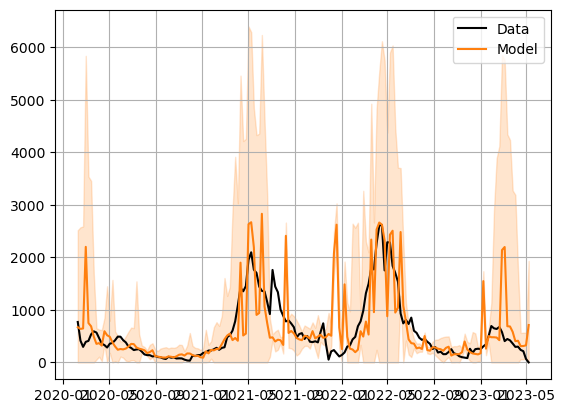

In [29]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_std[:,0], intervals_norm_knn_std[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [30]:
oob_predictions = model2.oob_prediction_

residuals_oob = y_prop_train - oob_predictions

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_oob, scaler=True)

display(de_knn_res)

sigmas_cal_knn_res = de_knn_res.apply(X_cal)

cr_norm_knn_res = ConformalRegressor()

cr_norm_knn_res.fit(residuals_cal, sigmas=sigmas_cal_knn_res)

display(cr_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [31]:
sigmas_test_knn_res = de_knn_res.apply(X_test)

intervals_norm_knn_res = cr_norm_knn_res.predict(y_hat_test, 
                                                 sigmas=sigmas_test_knn_res,
                                                 y_min=0)

display(intervals_norm_knn_res)

array([[0.00000000e+00, 1.97906993e+03],
       [0.00000000e+00, 2.11526901e+03],
       [0.00000000e+00, 1.84671821e+03],
       [0.00000000e+00, 5.01305474e+03],
       [0.00000000e+00, 2.68054631e+03],
       [0.00000000e+00, 2.59718903e+03],
       [0.00000000e+00, 1.36355775e+03],
       [0.00000000e+00, 9.03379341e+02],
       [0.00000000e+00, 8.88149670e+02],
       [0.00000000e+00, 9.79479963e+02],
       [5.18407007e+01, 1.13765930e+03],
       [0.00000000e+00, 1.37871474e+03],
       [0.00000000e+00, 1.68760054e+03],
       [0.00000000e+00, 1.24921092e+03],
       [0.00000000e+00, 8.89819337e+02],
       [0.00000000e+00, 6.86190227e+02],
       [0.00000000e+00, 5.66388726e+02],
       [0.00000000e+00, 5.56790213e+02],
       [0.00000000e+00, 5.58698532e+02],
       [0.00000000e+00, 7.03177144e+02],
       [0.00000000e+00, 7.84104411e+02],
       [5.82400688e+01, 6.40219931e+02],
       [0.00000000e+00, 8.06625551e+02],
       [9.88058187e+01, 4.25714181e+02],
       [1.019217

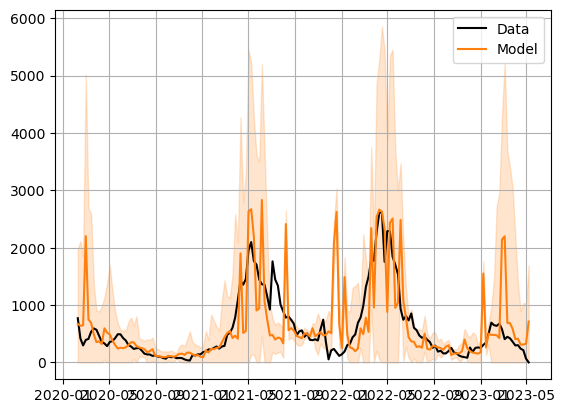

In [32]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_res[:,0], intervals_norm_knn_res[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [33]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=model2, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(X_cal)

cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [34]:
sigmas_test_var = de_var.apply(X_test)

intervals_norm_var = cr_norm_var.predict(y_hat_test, 
                                         sigmas=sigmas_test_var, 
                                         y_min=0)

display(intervals_norm_var)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

array([[0.00000000e+00, 2.87216550e+03],
       [0.00000000e+00, 1.80015804e+03],
       [2.11218858e+02, 1.08418114e+03],
       [0.00000000e+00, 1.00055178e+04],
       [0.00000000e+00, 1.88742478e+03],
       [0.00000000e+00, 1.92276873e+03],
       [0.00000000e+00, 1.20004157e+03],
       [1.54597303e+02, 5.54942697e+02],
       [0.00000000e+00, 7.82756015e+02],
       [5.96715599e+01, 5.83128440e+02],
       [0.00000000e+00, 1.86411178e+03],
       [0.00000000e+00, 1.11744853e+03],
       [0.00000000e+00, 1.00370490e+03],
       [1.47216668e+02, 6.17543332e+02],
       [1.20892631e+02, 4.87627369e+02],
       [9.27594313e+01, 3.93880569e+02],
       [8.07942714e+01, 4.32045729e+02],
       [1.04276929e+02, 3.94103071e+02],
       [1.06809287e+02, 4.22630713e+02],
       [9.81867721e+01, 5.07373228e+02],
       [1.47477136e+02, 5.59522864e+02],
       [1.53735302e+02, 5.44724698e+02],
       [1.15914268e+02, 4.54945732e+02],
       [1.08318524e+02, 4.16201476e+02],
       [5.536160

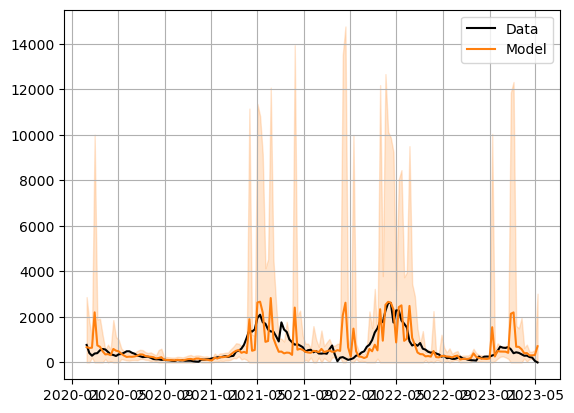

In [35]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_var[:,0], intervals_norm_var[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

Mondrial conformal regressor (não funcionou para esse caso)

bins_cal, bin_thresholds = binning(sigmas_cal_var, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals_cal, bins=bins_cal)

display(cr_mond)


bins_test = binning(sigmas_test_var, bins=bin_thresholds)

intervals_mond = cr_mond.predict(y_hat_test, bins=bins_test, y_min=0)

display(intervals_mond)

### Investigating the prediction intervals
Let us first put all the intervals in a dictionary.



In [36]:
prediction_intervals = {
    "Std CR":intervals,
    "Norm CR knn dist":intervals_norm_knn_dist,
    "Norm CR knn std":intervals_norm_knn_std,
    "Norm CR knn res":intervals_norm_knn_res,
    "Norm CR var":intervals_norm_var,
}


In [37]:
import numpy as np 
import pandas as pd 
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9294,1711.5070,1637.0300
Norm CR knn dist,0.9235,1412.6154,1410.2790
Norm CR knn std,0.8059,1522.8562,568.6355
Norm CR knn res,0.8647,1313.2233,676.2809
Norm CR var,0.8647,2156.6641,575.6306
Mean,0.8776,1623.3732,973.5712


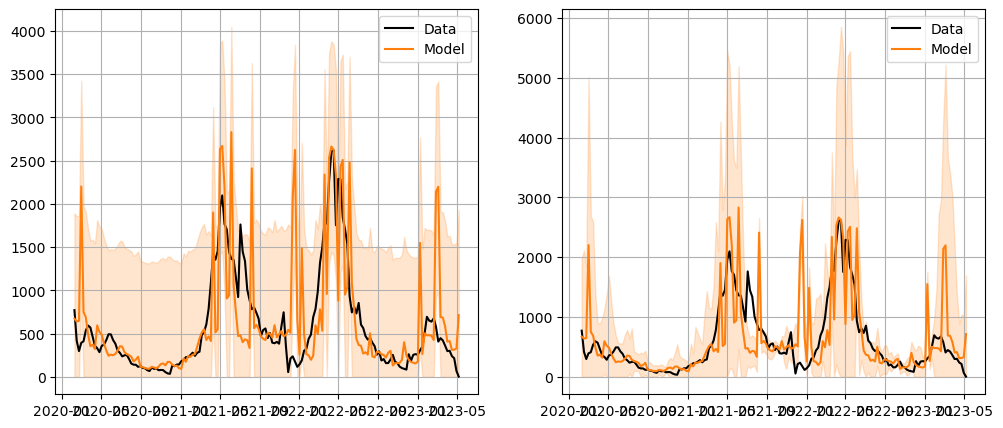

In [45]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

ax[0].plot(y_test, label = 'Data', color = 'black')

ax[0].plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax[0].fill_between(y_test.index, prediction_intervals['Std CR'][:,0],  prediction_intervals['Std CR'][:,1], color = 'tab:orange', alpha = 0.2)

ax[0].grid()

ax[0].legend()

ax[1].plot(y_test, label = 'Data', color = 'black')

ax[1].plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax[1].fill_between(y_test.index, prediction_intervals['Norm CR knn res'][:,0],  prediction_intervals['Norm CR knn res'][:,1], color = 'tab:orange', alpha = 0.2)

ax[1].grid()

ax[1].legend()


plt.show()
